In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:

from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/dataset-resized.zip", 'r')
zip_ref.extractall()
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['metal', 'cardboard', 'trash', 'plastic', 'paper', '.DS_Store', 'glass']

In [7]:

# Splitting the data in train, validate and test set.

def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)
 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [8]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [9]:

## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [10]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [11]:
data


ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [12]:
print(data.classes)


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


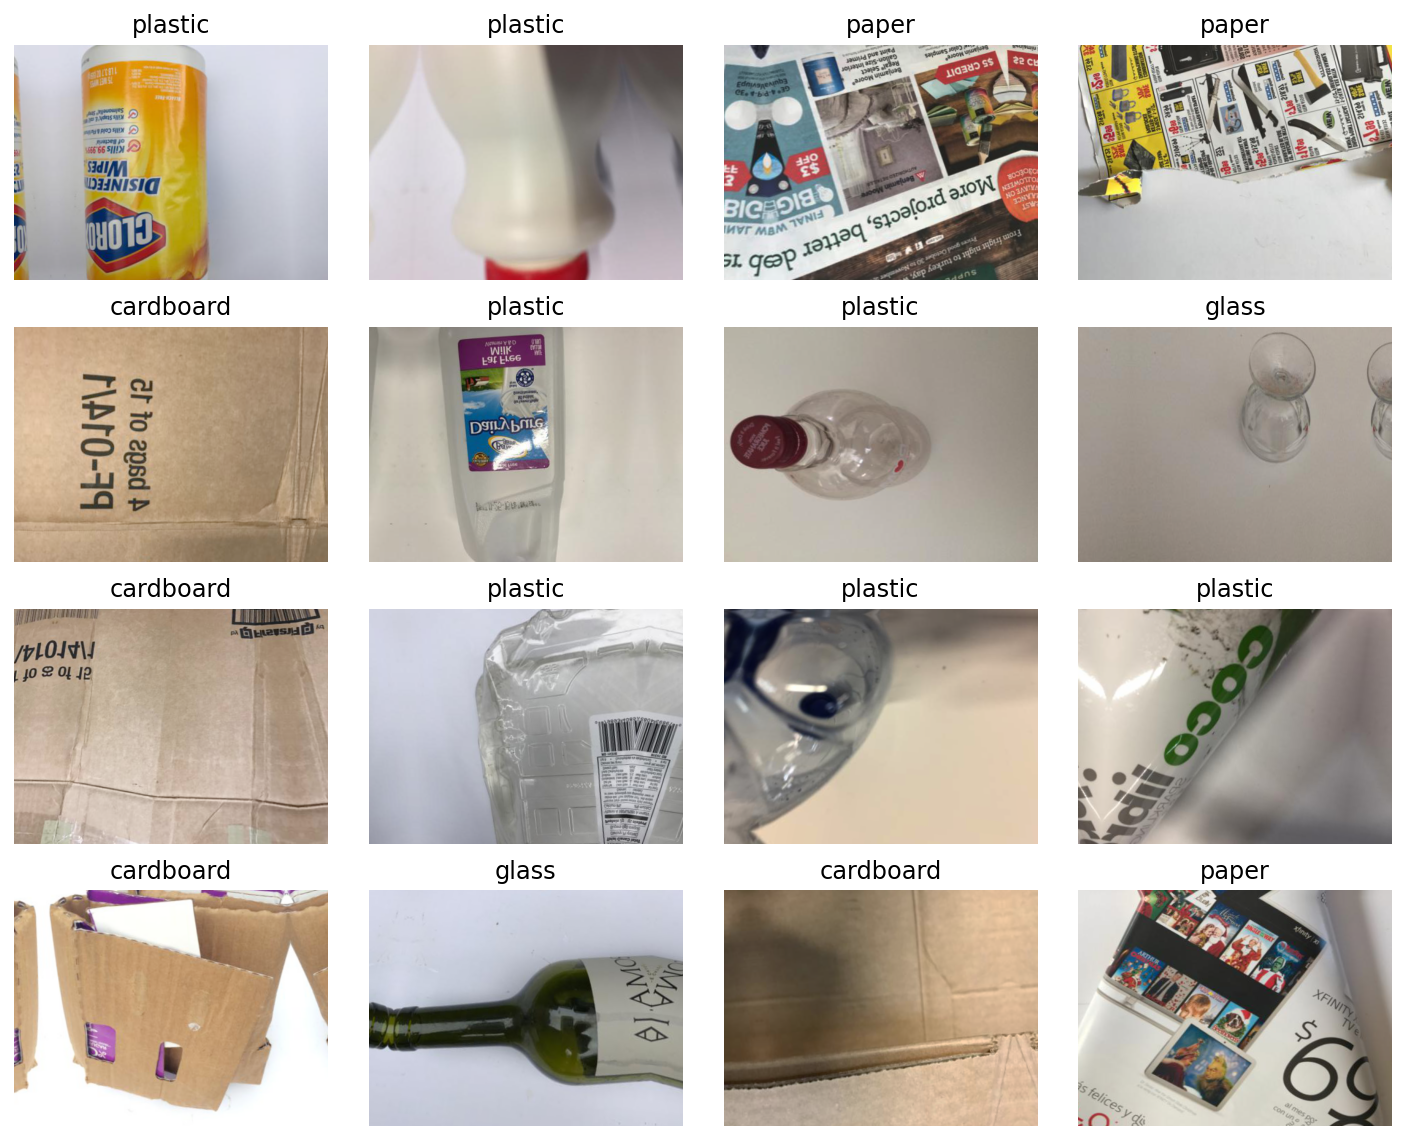

In [13]:
data.show_batch(rows=4,figsize=(10,8))

In [16]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


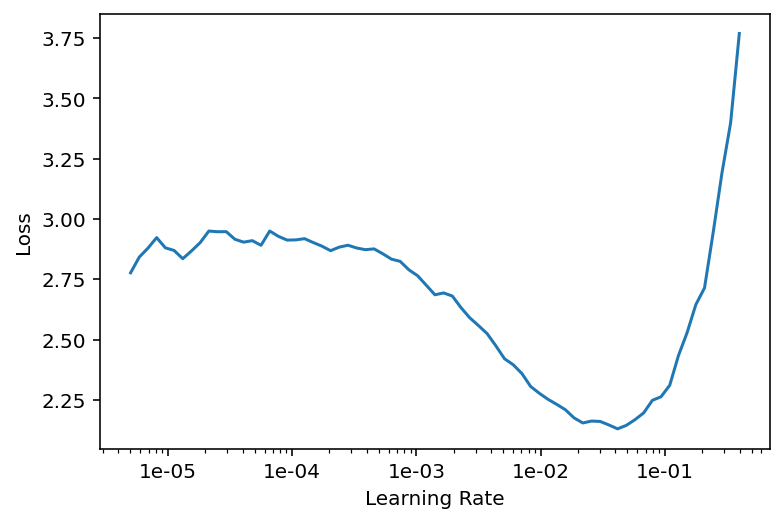

In [18]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(20,max_lr=5.13e-03)


epoch,train_loss,valid_loss,error_rate,time
0,1.603963,0.764621,0.284127,00:39
1,1.114224,0.541935,0.188889,00:38
2,0.854522,0.513122,0.152381,00:37
3,0.833210,0.664063,0.200000,00:37
4,0.847039,0.602379,0.193651,00:37
5,0.869534,0.663088,0.211111,00:37
6,0.788251,0.458617,0.166667,00:37
7,0.635568,0.672776,0.207937,00:36
8,0.662809,0.391020,0.138095,00:36
9,0.561361,0.514636,0.147619,00:36


In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

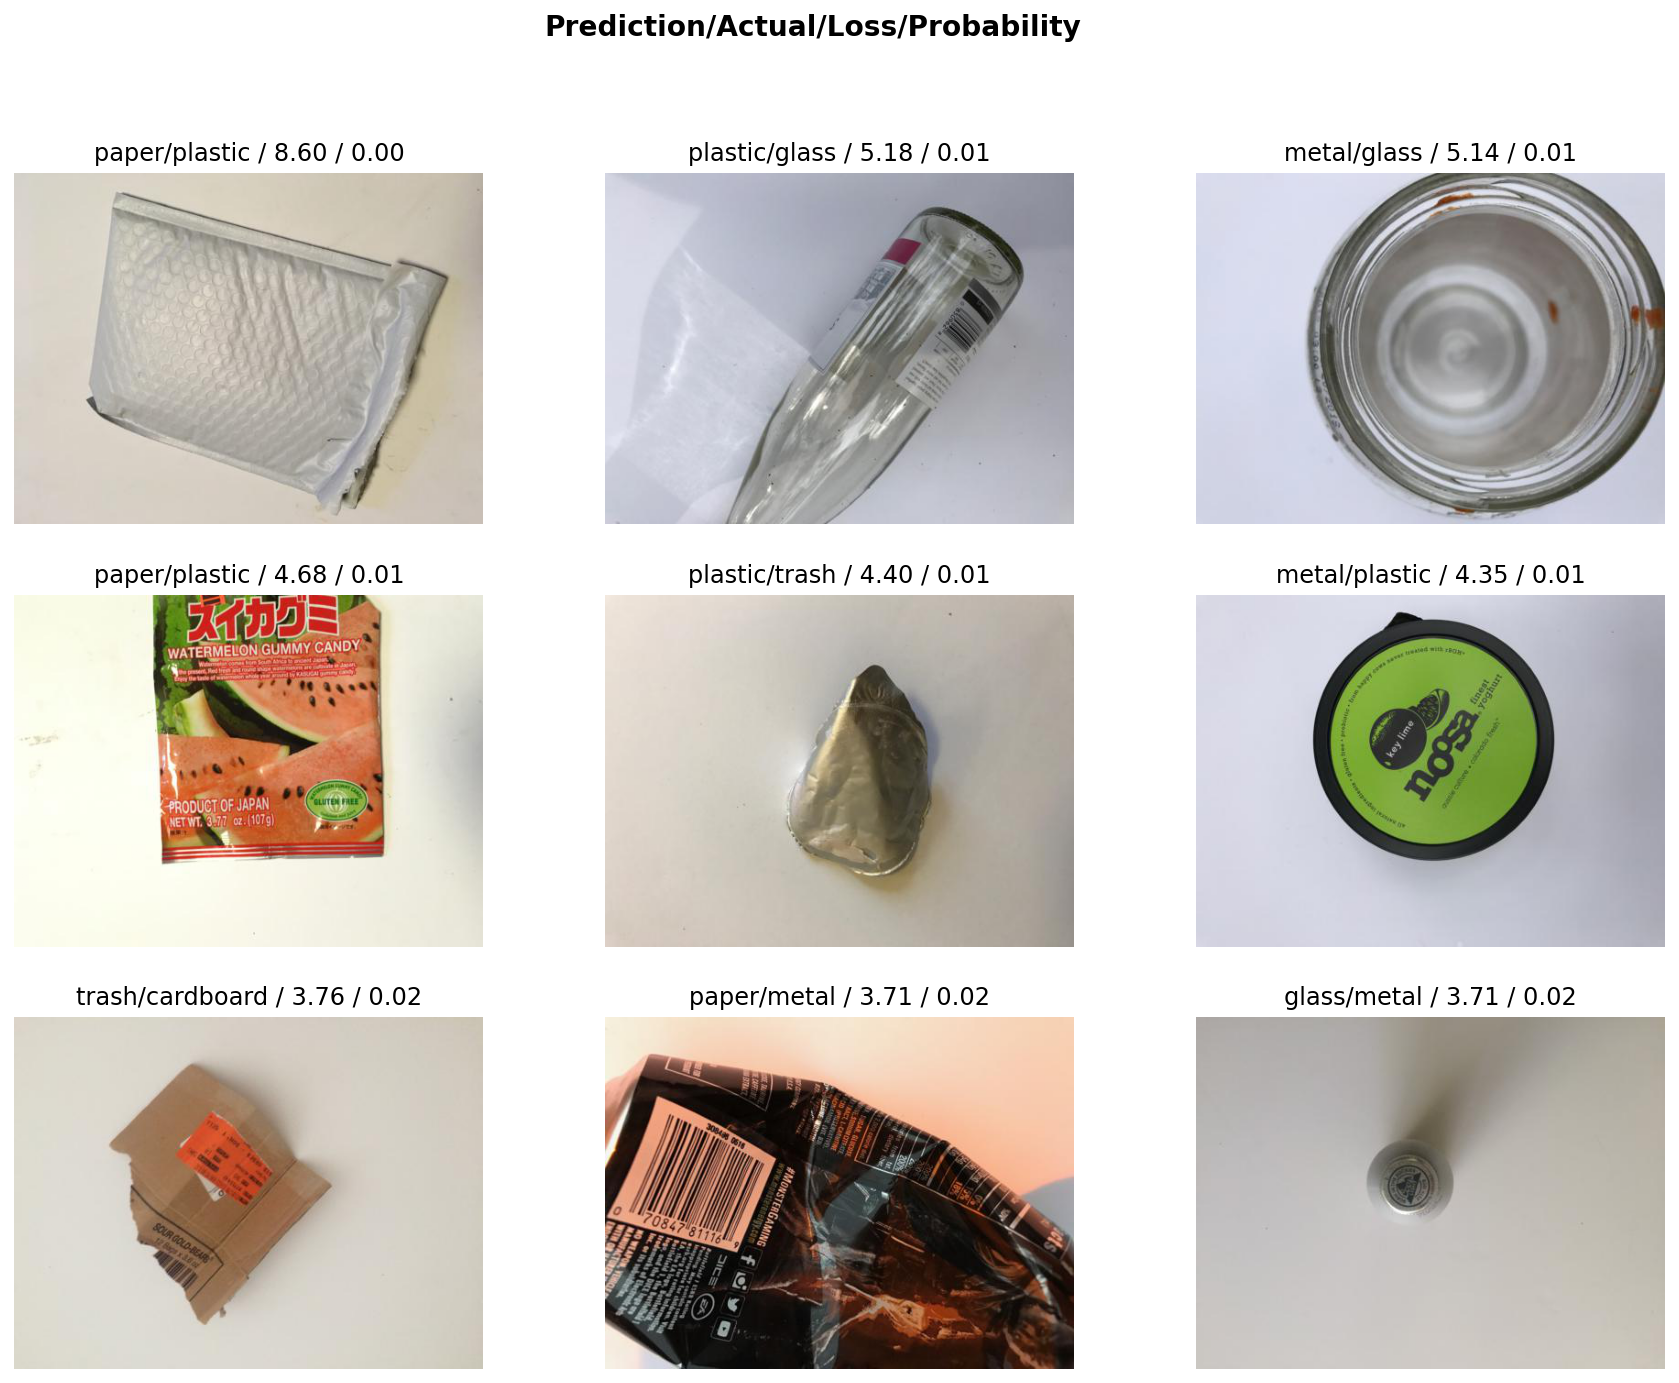

In [21]:
interp.plot_top_losses(9, figsize=(15,11))


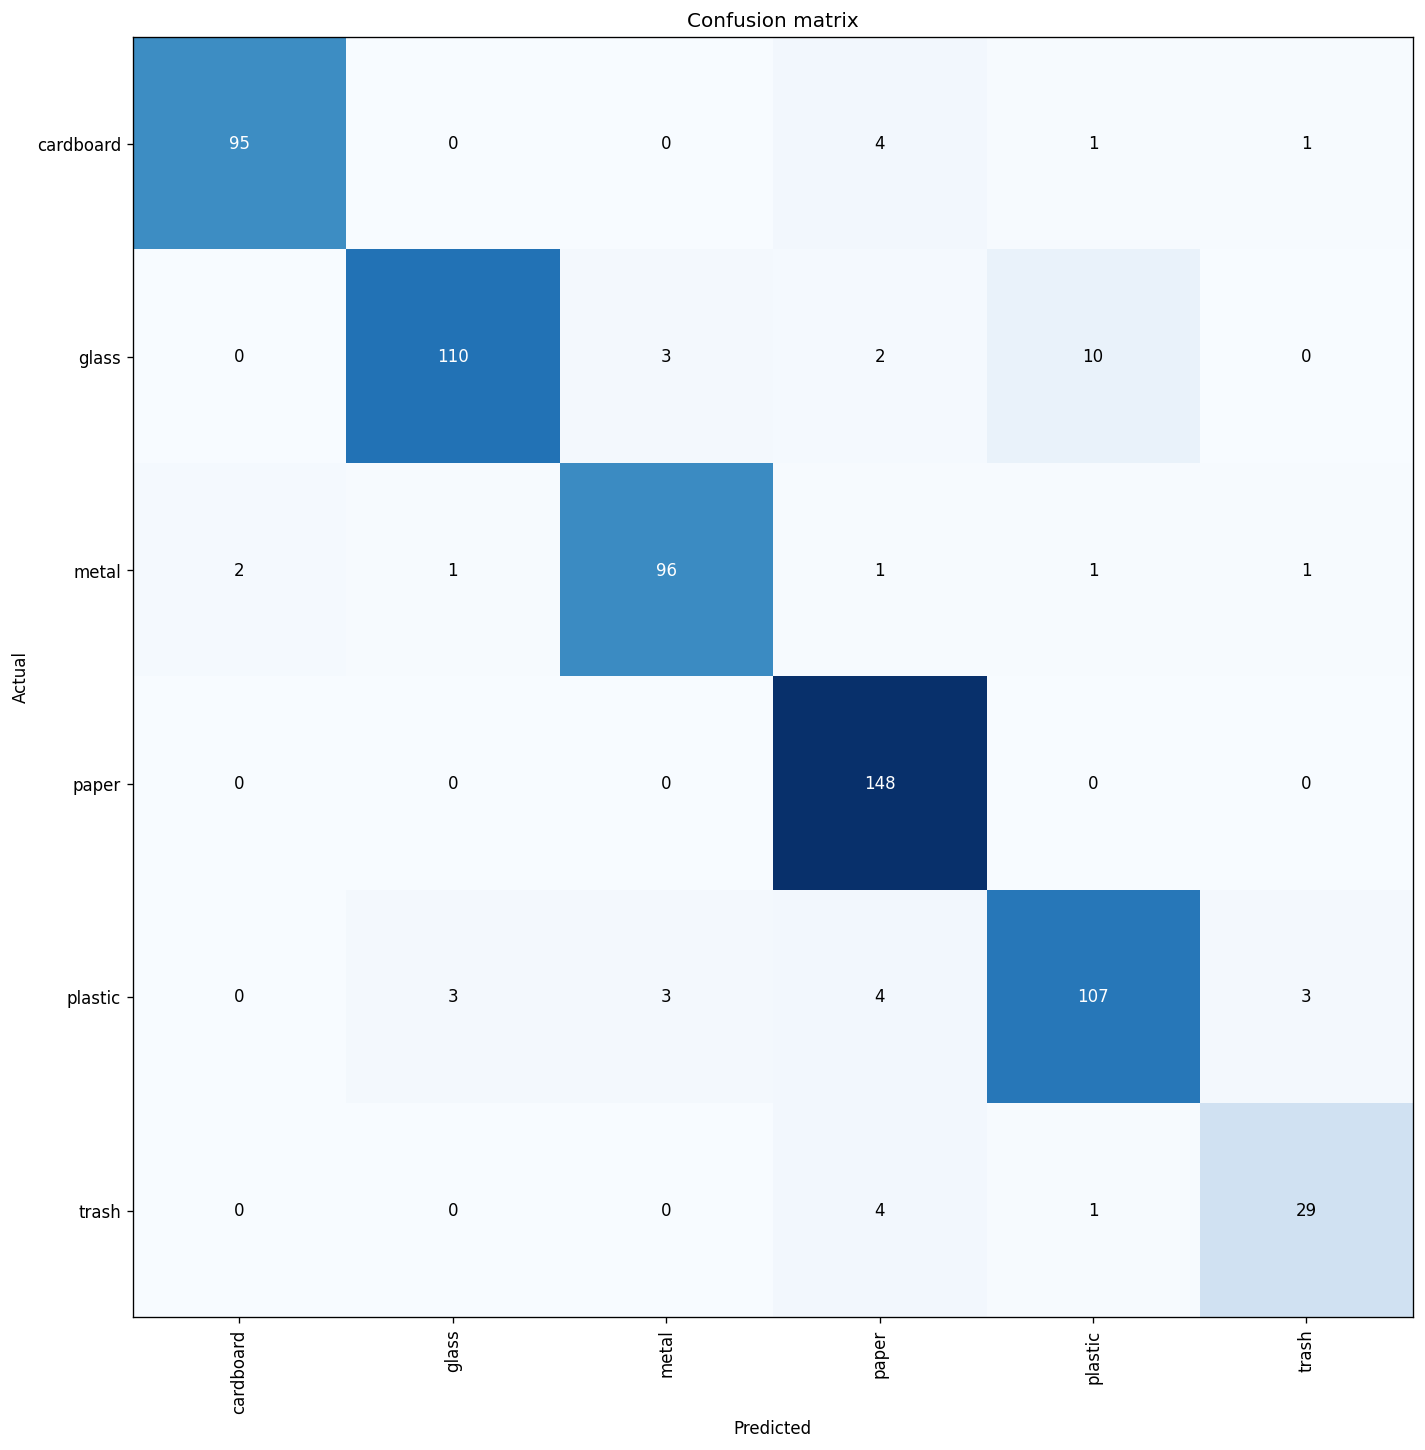

In [22]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 10),
 ('cardboard', 'paper', 4),
 ('plastic', 'paper', 4),
 ('trash', 'paper', 4),
 ('glass', 'metal', 3),
 ('plastic', 'glass', 3),
 ('plastic', 'metal', 3),
 ('plastic', 'trash', 3),
 ('glass', 'paper', 2),
 ('metal', 'cardboard', 2)]

In [24]:
preds = learn.get_preds(ds_type=DatasetType.Test)


In [25]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[3.3546e-03, 3.3377e-03, 1.2570e-03, 6.4028e-05, 9.9126e-01, 7.3046e-04],
        [3.3540e-06, 8.6442e-01, 8.0024e-02, 1.6012e-03, 4.0277e-03, 4.9922e-02],
        [5.2293e-04, 9.9464e-01, 3.6245e-05, 1.1012e-04, 4.6822e-03, 1.2835e-05],
        ...,
        [1.1848e-03, 8.9588e-04, 5.1096e-01, 8.1791e-04, 1.2449e-03, 4.8490e-01],
        [1.3445e-04, 3.7163e-01, 5.3482e-02, 1.8471e-02, 4.8656e-01, 6.9723e-02],
        [3.3201e-07, 2.4745e-05, 6.6018e-05, 2.5429e-06, 9.9990e-01, 5.3528e-06]])

In [26]:
data.classes


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [27]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))


In [28]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])


In [29]:

len(yhat)

635

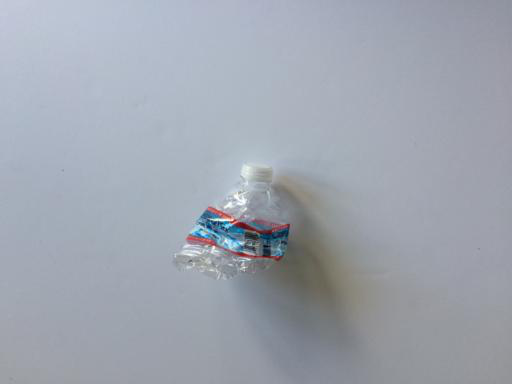

In [31]:
learn.data.test_ds[0][0]

In [32]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)


In [33]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['plastic', 'glass', 'glass', 'glass', 'glass']
['plastic', 'glass', 'glass', 'glass', 'glass']


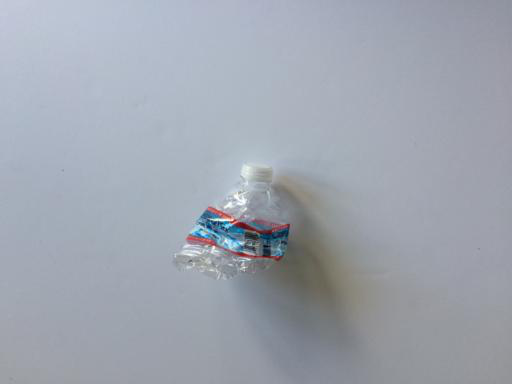

In [ ]:
learn.data.test_ds[0][0]

In [35]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   0   3   0   1]
 [  0 110   7   0   8   1]
 [  1   5  93   1   1   2]
 [  0   0   0 146   1   2]
 [  0   2   0   3 114   2]
 [  1   0   0   6   2  26]]


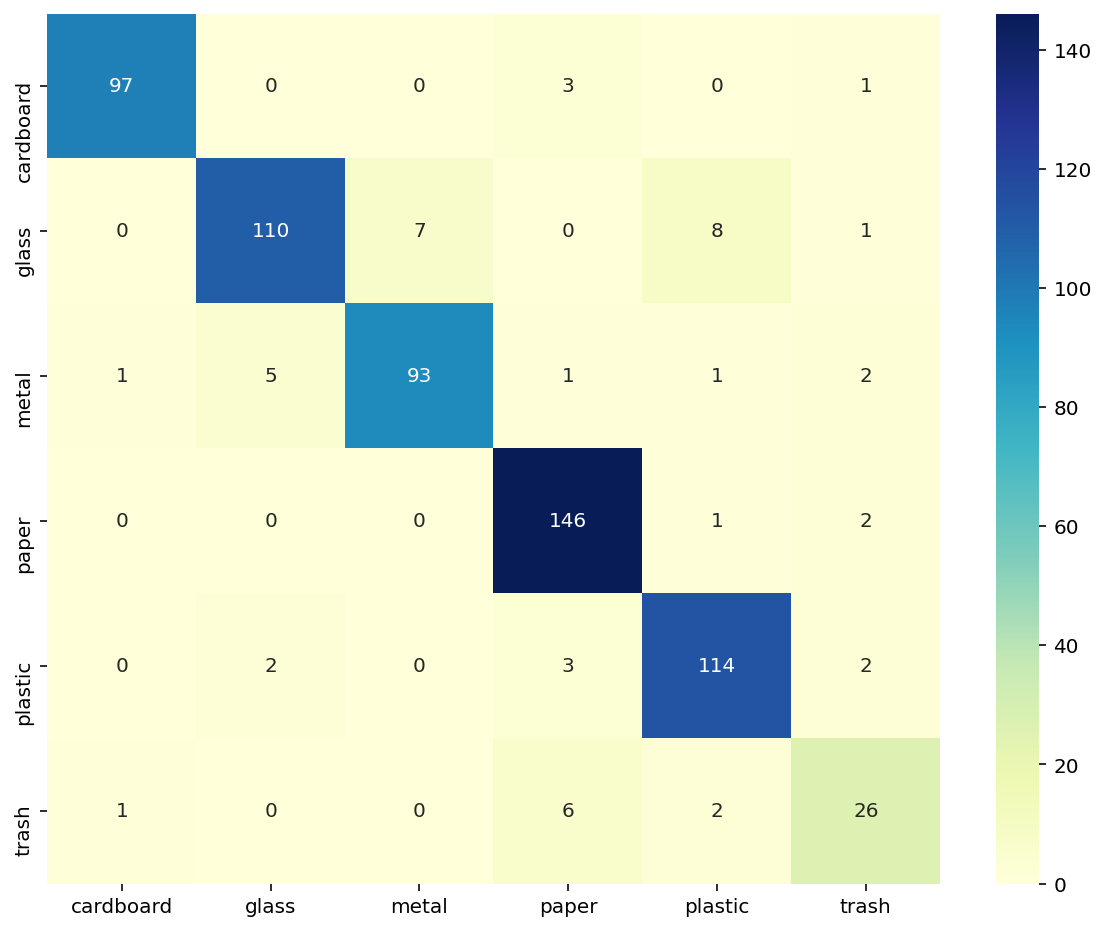

In [36]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [37]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [38]:
# Calculating the accuracy of the model

accuracy = correct/sum(sum(cm))
accuracy

0.9228346456692913

In [39]:
# Converting the test result into the dataframe

df = pd.DataFrame(yhat)

In [40]:
# Creating the column

print(type(df))
df['Type'] = ""

<class 'pandas.core.frame.DataFrame'>


In [41]:
# Here we are segregating the type of the waste into "Hazardous" and "Non-Hazardous"  based on the industrial criteria

for i in range(len(df)):
  if (df[0][i] == 'glass') or (df[0][i] == 'metal'):
    df['Type'][i]='Hazardous'
    
  else:
    df['Type'][i]='Non-Hazardous'

In [42]:
df

,0,Type
0,plastic,Non-Hazardous
1,glass,Hazardous
2,glass,Hazardous
3,glass,Hazardous
4,glass,Hazardous
...,...,...
630,paper,Non-Hazardous
631,paper,Non-Hazardous
632,metal,Hazardous
633,plastic,Non-Hazardous


In [ ]:
# Saving the classified 

df.to_csv("material.csv")